# How to run prysm.ice.d18O

## Preparation
Install some python packages:
```bash
pip install prysm
pip install LMRt
pip install wget pandas seaborn
```


In [1]:
import os
import pandas as pd
import numpy as np
import prysm
import pickle
import LMRt
import wget

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# download model simulation files, it may takes a while
os.makedirs('./data/model', exist_ok=True)
for varname in ['tas', 'pr', 'd18O', 'psl']:
    print(f'Downloading {varname} ...')
    url = f'https://atmos.washington.edu/~rtardif/LMR/prior/{varname}_sfc_Amon_iCESM_past1000historical_085001-200512.nc'
    wget.download(url, './data/model')

In [3]:
# load model simulation data
prior_dirpath = './data/model'
prior_filesdict = {
    'tas': os.path.join(prior_dirpath, 'tas_sfc_Amon_iCESM_past1000historical_085001-200512.nc'),
    'pr': os.path.join(prior_dirpath, 'pr_sfc_Amon_iCESM_past1000historical_085001-200512.nc'),
    'd18O': os.path.join(prior_dirpath, 'd18O_sfc_Amon_iCESM_past1000historical_085001-200512.nc'),
    'psl': os.path.join(prior_dirpath, 'psl_sfc_Amon_iCESM_past1000historical_085001-200512.nc'),
}
lat_model, lon_model, time_model, prior_vars = LMRt.utils.get_env_vars(prior_filesdict)

tas_model = prior_vars['tas']
pr_model = prior_vars['pr']
d18Opr_model = prior_vars['d18Opr']
psl_model = prior_vars['psl']

Renaming var: d18O -> d18Opr


In [4]:
# load topograph file if want to bias correct the temperature
with open('./data/topo_CESM.pkl', 'rb') as f:
    topo_CESM = pickle.load(f)

In [5]:
# load proxy database
df = pd.read_pickle('./data/pages2k_cleaned_dataset.pkl')
df = df[df['ptype']=='ice_d18O']

In [6]:
# check the first ice core data series
series = df.iloc[0]
print(series)

paleoData_pages2kID                                                 Arc_036
dataSetName                                           Arc-GRIP.Vinther.2010
archiveType                                                     glacier ice
geo_meanElev                                                           3238
geo_meanLat                                                           72.58
geo_meanLon                                                          322.36
year                      [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...
yearUnits                                                                AD
paleoData_variableName                                                 d18O
paleoData_units                                                      permil
paleoData_values          [-37.72, -39.33, -39.07, -39.44, -35.93, -35.9...
paleoData_proxy                                                        d18O
paleoData_notes             ; archiveType changed - was originally ice core
seasonality 

In [7]:
# run prysm.ice.d18O
lat_obs = series['geo_meanLat']
lon_obs = series['geo_meanLon']
elev_obs = series['geo_meanElev']  
proxy_time = series['year']
proxy_values = series['paleoData_values']

prysm_res = prysm.forward(
    'prysm.ice.d18O',
    lat_obs, lon_obs,
    lat_model, lon_model, time_model,
    {
        'tas': tas_model,
        'pr': pr_model,
        'psl': psl_model,
        'd18Opr': d18Opr_model,
    },
    elev_obs=elev_obs, elev_model=topo_CESM,
    verbose=True,
)

PRYSM >>> forward with prysm.ice.d18O ...
PRYSM >>> Target: (72.58, 322.36); Found: (72.95, 322.50); lat_ind: 86, lon_ind: 129
PRYSM >>> elev_obs: 3238.00, elev_model: 2891.70
PRYSM >>> mean(tas): 242.4965057373047 -> 240.41871643066406
PRYSM >>> shape: (1156,)
PRYSM >>> mean: -3.07; std: 0.04


In [8]:
# check the result dictionary
print(prysm_res.keys())

dict_keys(['pseudo_time', 'pseudo_value', 'd18O_ice', 'ice_diffused'])


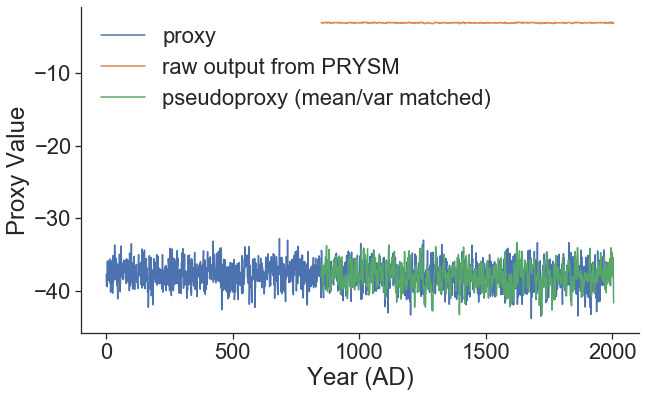

In [9]:
# visualization
sns.set(style='ticks', font_scale=2)                                                                                                                                           
fig, ax = plt.subplots(figsize=(10, 6)) 

ax.plot(proxy_time, proxy_values, label='proxy')
ax.plot(prysm_res['pseudo_time'], prysm_res['pseudo_value'], label='raw output from PRYSM')

match_res = LMRt.utils.ts_matching(prysm_res['pseudo_time'], prysm_res['pseudo_value'], proxy_time, proxy_values)
pseudoproxy = match_res['value_target']
ax.plot(prysm_res['pseudo_time'], pseudoproxy, label='pseudoproxy (mean/var matched)')
ax.legend(frameon=False, loc='upper left')
ax.set_xlabel('Year (AD)')
ax.set_ylabel('Proxy Value')
ax.spines['right'].set_visible(False)                                                                                                                                             
ax.spines['top'].set_visible(False)